In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.style.use("ggplot")

In [4]:
def ranges(barray):
    idxs = list(np.where(barray)[0])
    ranges = []
    for i in idxs:
        if ranges and i == ranges[-1][-1]:
            ranges[-1][-1] += 1
        else:
            ranges.append([i, i+1])
    return ranges

In [5]:
t_vals = np.linspace(-0.5, 1.5, 1000)
def plot_disease(disease_fn, show_treatment=False):
    bvals = disease_fn(t_vals)
    plt.plot(t_vals, bvals)
    if show_treatment:
        for low, high in ranges((bvals >= 0.5)[:-1]):
            plt.axvspan(t_vals[low], t_vals[high], color="green", alpha=0.5, lw=0)
    plt.xlabel("Time")
    plt.ylabel("Badness of Disease")

In [6]:
def with_measurement_error(fn, std=0.1):
    def f(t):
        z = fn(t)
        z += np.random.randn(np.size(z)) * std
        return z
    return f

In [7]:
def cold(t):
    return (t < 0) * 0 + (0 <= t) * (t < 0.3) * t / 0.3 + (0.3 <= t) * (t < 1) * (1 - t) / (1 - 0.3)

In [8]:
def plot_with_and_without_error(fn, name, show_treatment=False):
    treat = "_treat" if show_treatment else ""
    for short, long in ("truth", "Ground Truth"),: #, ("perceived", "As Perceived"):
        np.random.seed(1)
        plot_disease(fn if short == "truth" else with_measurement_error(fn),
                     show_treatment=show_treatment)
        plt.title("%s [%s]" % (name, long))
        plt.savefig("%s_%s_bad%s.png" % (name.lower(), short, treat))
        plt.show()

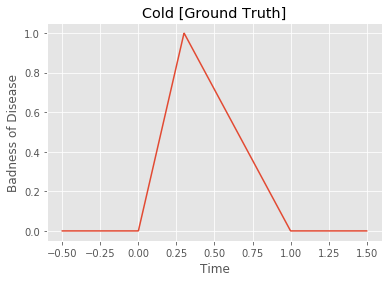

In [9]:
plot_with_and_without_error(cold, "Cold")

In [10]:
def chronic(t):
    r = np.random.randn(*t.shape)
    return sum(np.roll(r, k) for k in range(t.size // 20)) / np.sqrt(t.size // 20)

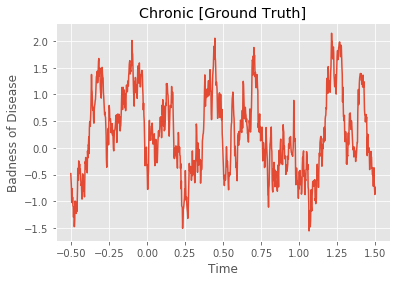

In [11]:
plot_with_and_without_error(chronic, "Chronic")

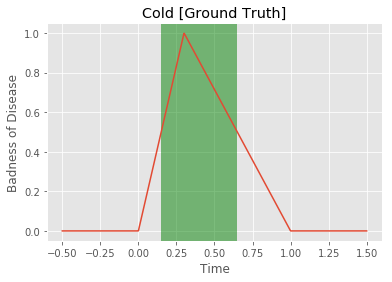

In [12]:
plot_with_and_without_error(cold, "Cold", show_treatment=True)

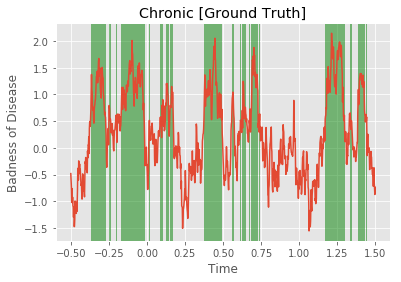

In [13]:
plot_with_and_without_error(chronic, "Chronic", show_treatment=True)

In [14]:
def relative_hist(data, **kwargs):
    return plt.hist(data, weights=np.zeros_like(data) + 1. / data.size, **kwargs)

In [15]:
def plot_95ci(data):
    boot = np.mean(np.random.choice(data, size=(data.size, data.size)), axis=0)
    plt.axvspan(np.percentile(boot, 2.5), np.percentile(boot, 97.5), alpha=0.25, label="95% CI of the mean")

In [16]:
def plot_regress(fn, short, name):
    np.random.seed(1)
    y_vals = fn(t_vals)
    t_treat = np.random.choice(np.where(y_vals[:-200] >= 0.5)[0], size=10000)
    t_check = t_treat + 200
    diffs = y_vals[t_treat] - y_vals[t_check]
    relative_hist(diffs, bins=10, label="Improvement Amount")
    plt.axvline(0, label="No improvement [%.2f%% below this line]" % (100 * np.mean(diffs < 0)))
    plt.xlabel("Improvement from Treatment to Check")
    plt.ylabel("Frequency")
    plt.title(name)
    plt.legend()

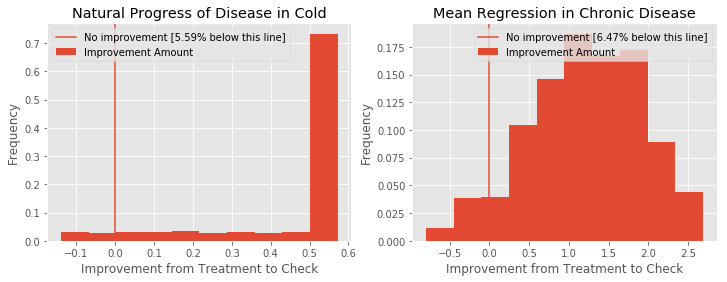

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_regress(cold, "cold", "Natural Progress of Disease in Cold")
plt.subplot(122)
plot_regress(chronic, "chronic", "Mean Regression in Chronic Disease")
plt.savefig("improvement_natural")

In [18]:
def plot_treatment(fn, short, name, maximum=1):
    np.random.seed(1)
    y_vals = fn(t_vals)
    t_treat = np.random.choice(np.where(y_vals[:-200] >= 0.5)[0], size=10000)
    t_check = t_treat + 200
    diffs = y_vals[t_treat] - y_vals[t_check]
    wvals = np.linspace(0, maximum, 100)
    treated_diffs = [np.mean(diffs - w + np.random.randn(*diffs.shape)) for w in wvals]
    plt.plot(wvals, treated_diffs)
    plt.xlabel("Amount of Chemical W")
    plt.ylabel("Mean Improvement")
    plt.title("Improvement by Chemical W on %s" % name)
    plt.axhline(0, linestyle='-.', color='k', lw=1)

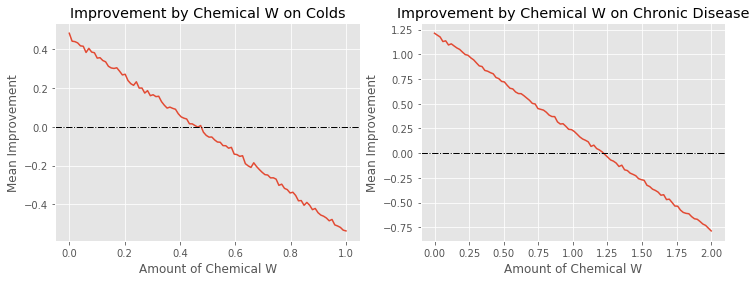

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_treatment(cold, "cold", "Colds")
plt.subplot(122)
plot_treatment(chronic, "chronic", "Chronic Disease", maximum=2)
plt.savefig("improvement_treatment")

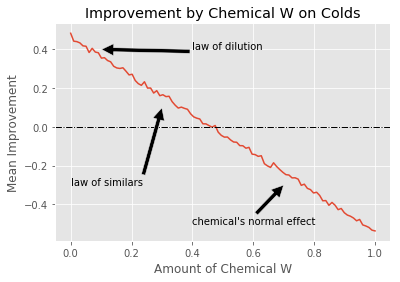

In [20]:
plot_treatment(cold, "cold", "Colds")
plt.annotate("chemical's normal effect", xy=(0.7, -0.3), xytext=(0.4, -0.5),
        arrowprops=dict(facecolor='black', shrink=0.005))
plt.annotate("law of similars", xy=(0.3, 0.1), xytext=(0, -0.3),
        arrowprops=dict(facecolor='black', shrink=0.005))
plt.annotate("law of dilution", xy=(0.1, 0.4), xytext=(0.4, 0.4),
        arrowprops=dict(facecolor='black', shrink=0.005))
plt.savefig("improvement_treatment_annotated")